# Neural Network Training with Torch on  Iris Flower Dataset

### written by Dr. Bertalan Jóni

Project structure:
- Exploratory Data Analysis
- Data Preparation with Pipeline
- Neural Network training with PyTorch

# 1. Exploratory Data Analysis

In this section, we are not going to modify the loaded data, just analyze it. However, we will create some copies of the dataset and we will modify them in order to explore our data and to see the effects of the different aspects of data preparation. The real data preparation will be performed in the next chapter using a pipeline. The major observations of EDA will be summarized at the end of the section.

In [263]:
# import necessary libraries
import re
import requests
import copy
from copy import deepcopy
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 200)

import warnings
warnings.filterwarnings('ignore')

import missingno as msno
import tqdm

from sklearn.model_selection import (
    TimeSeriesSplit, train_test_split, cross_val_score, cross_validate,
    GridSearchCV
)
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import cross_validate
from sklearn.metrics import (
    make_scorer, accuracy_score, precision_score, recall_score,
    f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve,
    mean_squared_error, r2_score, mean_absolute_error, explained_variance_score,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.init as init
torch.manual_seed(23)

**Load Data:**

In [118]:
# load iris dataframe
from sklearn import datasets

iris = datasets.load_iris()

df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
target_names = {
    0:'setosa',
    1:'versicolor', 
    2:'virginica'
}
target_variable = 'species'
df[target_variable] = iris.target
df['species_names'] = df['species'].map(target_names)

col_names = list(df.columns)
numerical = df.select_dtypes(['int64', 'int32', 'int16', 'int8', 'float64', 'float32', 'float16']).columns.tolist()
features = iris.feature_names

"""
# alternative load:
iris = datasets.load_iris()
df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df['species'] = iris.target
df['species_names'] = pd.Categorical.from_codes(iris.target, iris.target_names)
"""

"\n# alternative load:\niris = datasets.load_iris()\ndf = pd.DataFrame(data=iris.data, columns=iris.feature_names)\ndf['species'] = iris.target\ndf['species_names'] = pd.Categorical.from_codes(iris.target, iris.target_names)\n"

In [119]:
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species,species_names
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa


**Checking the data and performing basic statistics:**

In [120]:
# data types of the columns and count null values
df.info()
print("\nNumber of rows in dataset:",df.shape[0])
print("Number of columns in dataset:",df.shape[1])
print(f"\nMissing values:\n{df.isna().sum()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   species            150 non-null    int32  
 5   species_names      150 non-null    object 
dtypes: float64(4), int32(1), object(1)
memory usage: 6.6+ KB

Number of rows in dataset: 150
Number of columns in dataset: 6

Missing values:
sepal length (cm)    0
sepal width (cm)     0
petal length (cm)    0
petal width (cm)     0
species              0
species_names        0
dtype: int64


In [121]:
# Check duplicates
num_duplicates = (df.duplicated() == True).sum()
print(f"duplicates: {num_duplicates if num_duplicates > 0 else 'there are no duplicates in the dataframe'}")

duplicates: 1


In [122]:
df.drop_duplicates(inplace=True)

In [123]:
num_duplicates = (df.duplicated() == True).sum()
print(f"duplicates: {num_duplicates if num_duplicates > 0 else 'there are no duplicates in the dataframe'}")

duplicates: there are no duplicates in the dataframe


In [124]:
df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
count,149.000000,149.000000,149.000000,149.000000,149.000000
mean,5.843624,3.059732,3.748993,1.194631,0.993289
std,0.830851,0.436342,1.767791,0.762622,0.817847
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.300000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


In [167]:
df['species_names'].unique()

array(['setosa', 'versicolor', 'virginica'], dtype=object)

**Missing values:**

In [125]:
# functions for analyse missing values

def visualize_nan(df, plot_type='heatmap', figsize=(10, 6), title='Missing Values'):

    if plot_type == 'heatmap':
        plt.figure(figsize=figsize)
        sns.heatmap(df.isna(), yticklabels=False, cmap='crest')
        plt.title(title)
    elif plot_type == 'bar':
        msno.bar(df)
        plt.title(title)
    elif plot_type == 'matrix':
        msno.matrix(df)
        plt.title(title)
    elif plot_type == 'correlation':
        msno.heatmap(df)
        plt.title(title)

    plt.show()


def missing_percentage(df, show_all_info=False):

    total_missing = df.isnull().sum().sort_values(ascending=False)
    percent_missing = (total_missing / len(df)) * 100
    missing_info = pd.concat([total_missing, percent_missing], axis=1, keys=['Missing Values', '[%]'])

    if not show_all_info:
        missing_info = missing_info[missing_info['Missing Values'] > 0]
    return missing_info

def missing_info(df, visualize=True, report=True, plot_type='heatmap', figsize=(10, 6), title='Missing Values', show_all_info=False):
    """
    Displays missing values information and visualizes them using missingno library.

    Parameters:
    - df (pd.DataFrame): The dataframe to analyze.
    - visualize (bool, optional): Whether to visualize missing values. Default is True.
    - report (bool, optional): Whether to print missing values report. Default is True.
    - plot_type (str, optional): Type of plot to generate when visualizing. Options: 'heatmap', 'bar', 'matrix', 'correlation'. Default is 'heatmap'.
    - figsize (tuple, optional): Figure size for visualizations. Default is (10, 6).
    - title (str, optional): Title of the plot when visualizing. Default is 'Missing Values'.
    - show_all_info (bool, optional): Whether to display information for all columns in the report. Default is False.

    Examples:
    missing_info(train_data, visualize=True, report=True, plot_type='heatmap')
    missing_info(train_data, visualize=False, report=True, show_all_info=True)
    """
    if visualize: visualize_nan(df, plot_type=plot_type, figsize=figsize, title=title)
    if report: print(missing_percentage(df, show_all_info=show_all_info))

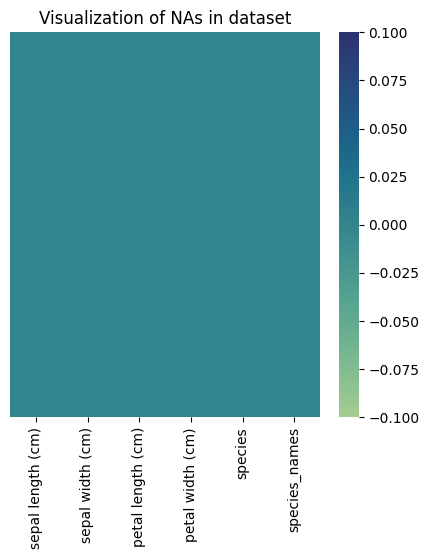

                   Missing Values  [%]
sepal length (cm)               0  0.0
sepal width (cm)                0  0.0
petal length (cm)               0  0.0
petal width (cm)                0  0.0
species                         0  0.0
species_names                   0  0.0


In [126]:
missing_info(df, visualize=True, report=True, show_all_info=True, plot_type='heatmap', title='Visualization of NAs in dataset', figsize=(5, 5))

**Outliers:**

In [127]:
def plot_boxplots(df, features, hue):
    fig, axes = plt.subplots(1, len(features), figsize=(15, 5))
    fig.subplots_adjust(wspace=0.5)

    for i, col in enumerate(features):
        sns.boxplot(data=df, x=hue, y=col, ax=axes[i])
        axes[i].set_title(f'{col}')

    fig.suptitle('Boxplots for Features', fontsize=12)
    plt.tight_layout()
    plt.show()

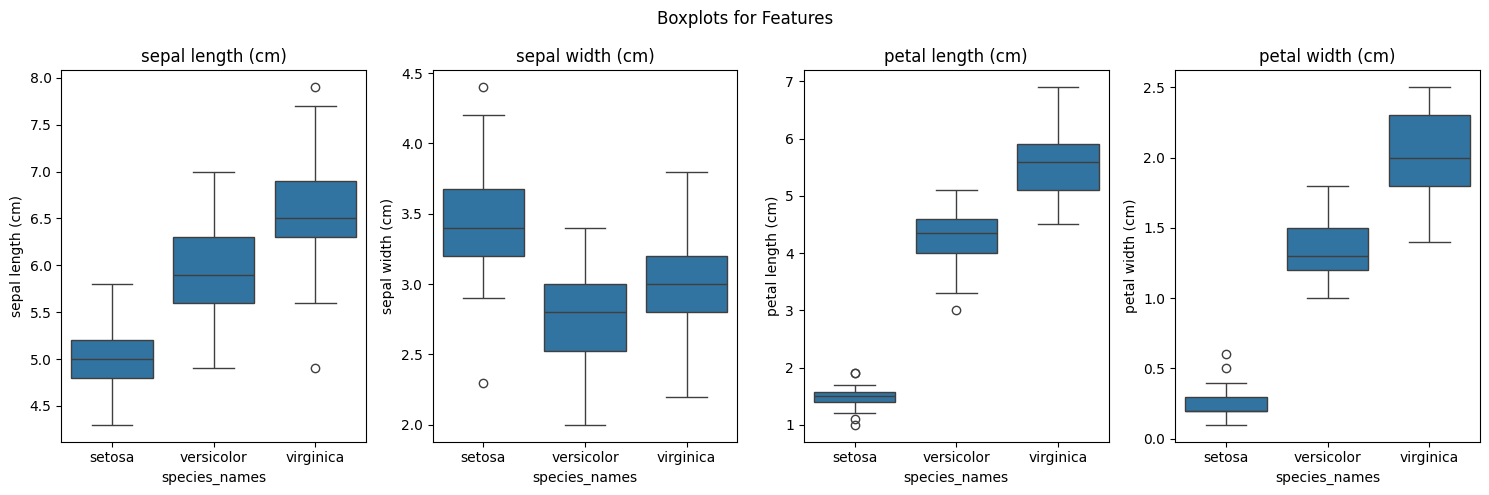

In [128]:
plot_boxplots(df, features, 'species_names')

In [129]:
# Plot boxenplots
def plot_boxenplot(df, numeric_vars, figsize=(24, 15), title='Boxenplots for Numerical Features'):
    num_vars_count = len(numeric_vars)
    num_cols = 4
    num_rows = math.ceil(num_vars_count / num_cols)
    
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=figsize)
    
    for i, var in enumerate(numeric_vars):
        row = i // num_cols
        col = i % num_cols
        #sub = axes[row, col]
        if num_rows == 1:
            sub = axes[i % num_cols]
        else:
            sub = axes[row, col]
        sub.set_xlabel(var)
        sns.boxenplot(data=df, x=var, ax=sub)
    
    fig.suptitle(t=title, fontsize=18)
    plt.show()

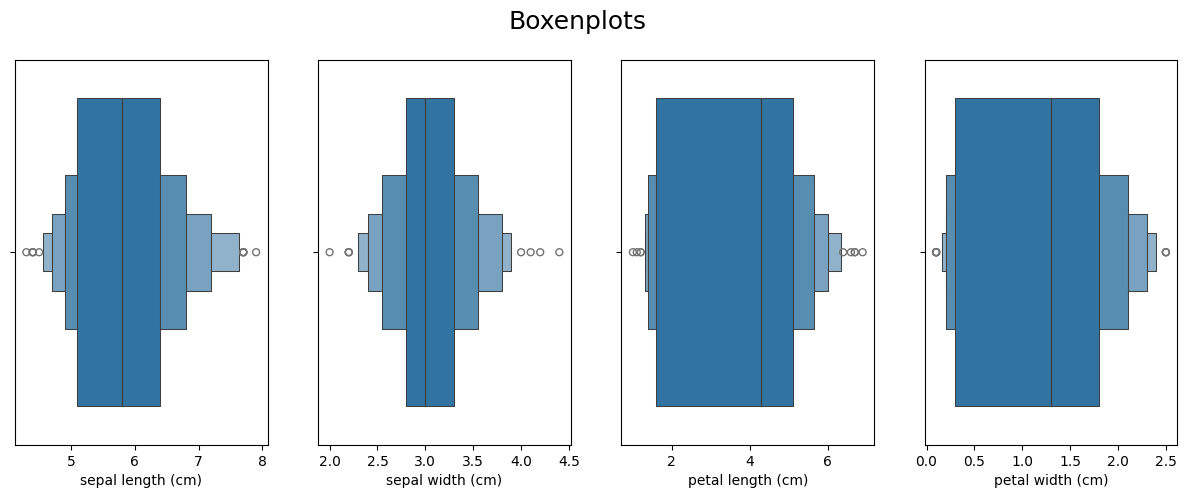

In [130]:
plot_boxenplot(df, features, title='Boxenplots', figsize=(15, 5))

In [131]:
def cap_outliers(train_data, columns, test_data=None, threshold=1.5, verbose=False):
    """
    Capping outliers in specified columns of the datasets.

    Parameters:
    - train_data (pd.DataFrame): The training dataset.
    - columns (list): A list of column names in which outliers will be capped.
    - test_data (pd.DataFrame, optional): The optional test dataset. Default is None.
    - threshold (float, optional): The threshold for identifying outliers. Default is 1.5.

    Returns:
    - train_out (pd.DataFrame): The training dataset with capped outliers.
    - test_out (pd.DataFrame, optional): The test dataset with capped outliers if provided; otherwise, None.

    Examples:
    train_data, test_data = cap_outliers(train_data, ['feature1', 'feature2'], test_data=test_data)
    """
    
    # Copy the original dataframes to avoid modifying the input directly
    train_out = train_data.copy()

    # If test_data is provided, create a copy; otherwise, set test_out to None
    test_out = test_data.copy() if test_data is not None else None

    # Calculate outlier bounds based on train data
    for column in columns:
        lower_bound = train_out[column].quantile(0.25) - threshold * (train_out[column].quantile(0.75) - train_out[column].quantile(0.25))
        upper_bound = train_out[column].quantile(0.75) + threshold * (train_out[column].quantile(0.75) - train_out[column].quantile(0.25))

        # Count capped outliers in train data
        num_capped_train = np.sum((train_out[column] < lower_bound) | (train_out[column] > upper_bound))
        num_capped_test = None

        # Cap outliers in train data
        train_out[column] = np.where(train_out[column] < lower_bound, lower_bound, train_out[column])
        train_out[column] = np.where(train_out[column] > upper_bound, upper_bound, train_out[column])

        # If test_data is provided, cap outliers in test data using bounds from train data
        if test_out is not None:
            num_capped_test = np.sum((test_out[column] < lower_bound) | (test_out[column] > upper_bound))
            test_out[column] = np.where(test_out[column] < lower_bound, lower_bound, test_out[column])
            test_out[column] = np.where(test_out[column] > upper_bound, upper_bound, test_out[column])

        if verbose:
            if test_out is not None:
                print(f"Column '{column}': {num_capped_train} outliers capped in train data.")
                print(f"{11*' '}{len(column)*' '}{num_capped_test} outliers capped in test data.")
            else:
                print(f"Column '{column}': {num_capped_train} outliers capped in data.")
                
    if test_out is not None:
        return train_out, test_out
    else:
        return train_out

In [132]:
df_cap = cap_outliers(df, features, threshold=1.5, verbose=True)

Column 'sepal length (cm)': 0 outliers capped in data.
Column 'sepal width (cm)': 4 outliers capped in data.
Column 'petal length (cm)': 0 outliers capped in data.
Column 'petal width (cm)': 0 outliers capped in data.


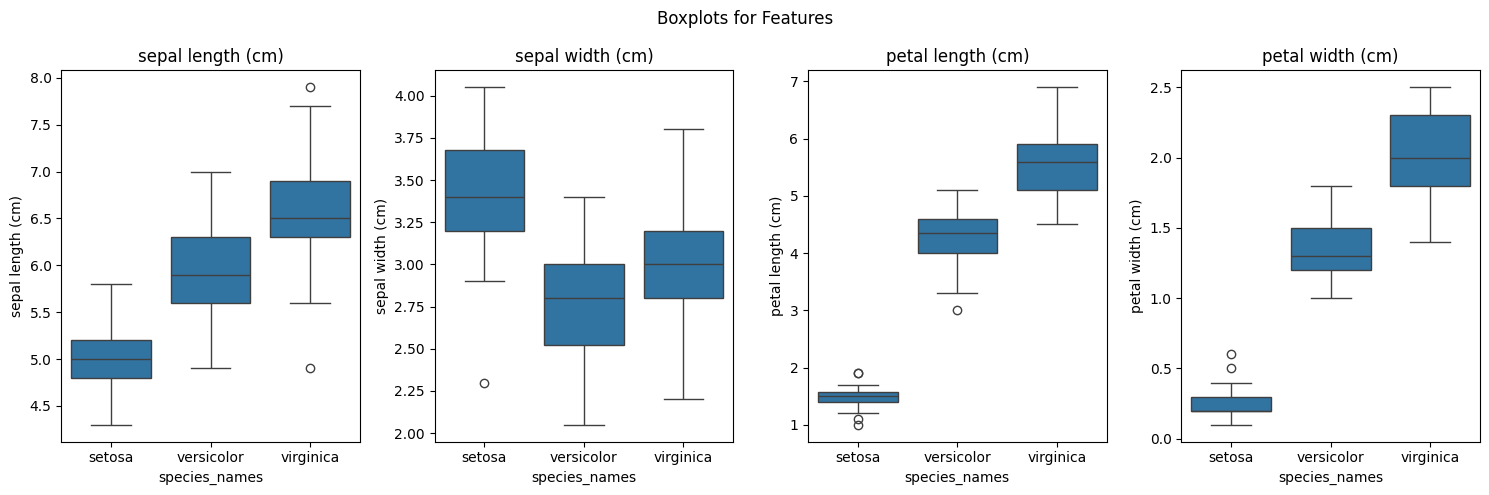

In [133]:
plot_boxplots(df_cap, features, 'species_names')

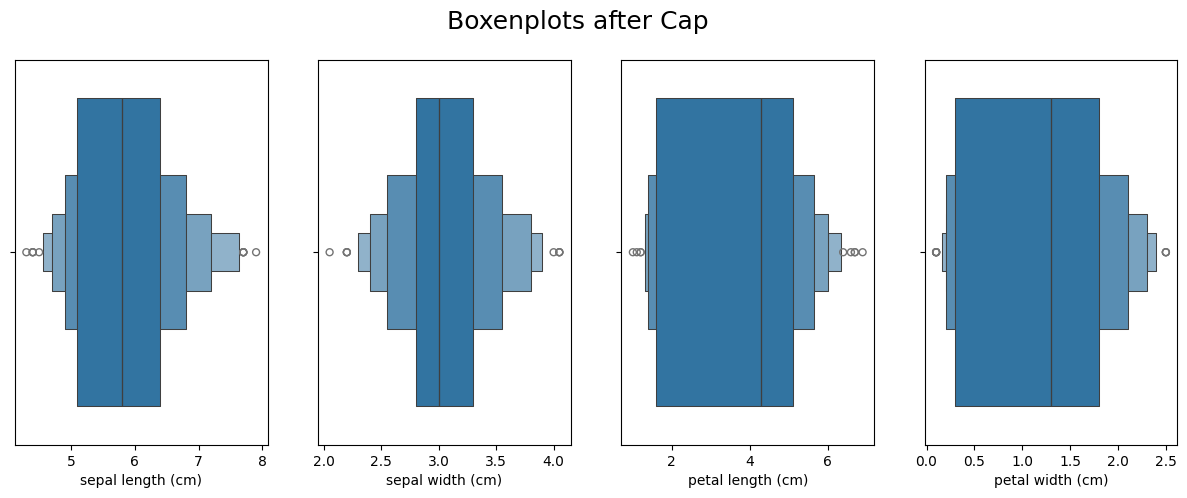

In [134]:
plot_boxenplot(df_cap, features, title='Boxenplots after Cap', figsize=(15, 5))

**Analyzing the target variable and the distributions of the features:**

In [247]:
# Analyzing the target variable
def analyzing_target(df, y):
    # The Target variable/Dependent variable is categorical in nature: yes/no.
    print(f'\nTarget variable values: {df[y].unique()}')
    print(f'\nValue counts of the target variable:\n{df[y].value_counts()}')
    
    # Create a pie chart and count plot (column chart) for y target variable
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    
    # Column chart
    sns.countplot(data=df, x=y, ax=axes[0])
    axes[0].set_title(f'Count Plot of "{y}" target variable')
    
    # Pie chart
    axes[1].pie(df[y].value_counts(), labels=df[y].value_counts().index, autopct='%1.1f%%', startangle=90, )
    axes[1].axis('equal')
    axes[1].set_title(f'Distribution of "{y}" target variable')
    
    plt.tight_layout()
    plt.show()


Target variable values: ['setosa' 'versicolor' 'virginica']

Value counts of the target variable:
species_names
setosa        50
versicolor    50
virginica     49
Name: count, dtype: int64


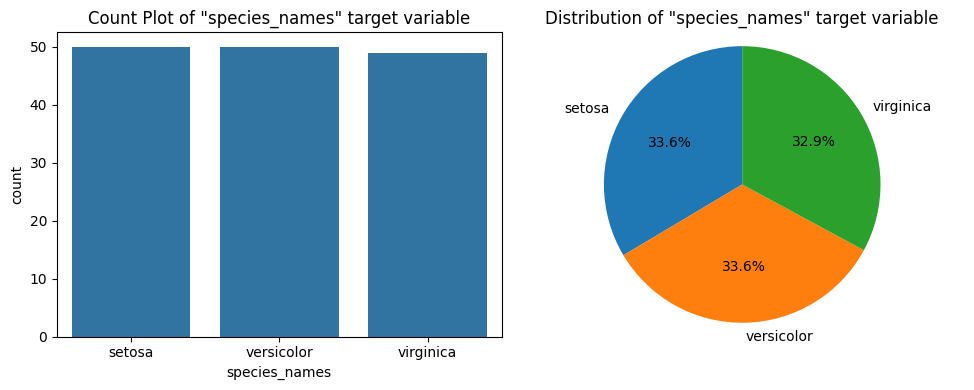

In [248]:
analyzing_target(df_cap, y='species_names')

In [138]:
# plot distributions
def plot_distribution(df, numeric_vars, hue=None, kde=True, bins='auto', stat='count', figsize=(24, 15), title='Distribution Plots for Numerical Features'):
    num_vars_count = len(numeric_vars)
    num_cols = 4
    num_rows = math.ceil(num_vars_count / num_cols)
    
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=figsize)
    
    for i, var in enumerate(numeric_vars):
        row = i // num_cols
        col = i % num_cols
        #sub = axes[row, col]
        if num_rows == 1:
            sub = axes[i % num_cols]
        else:
            sub = axes[row, col]
        sub.set_xlabel(var)
        sns.histplot(data=df, x=var, kde=kde, bins=bins, stat=stat,  ax=sub, hue=hue)
    
    fig.suptitle(t=title, fontsize=18)
    plt.show()

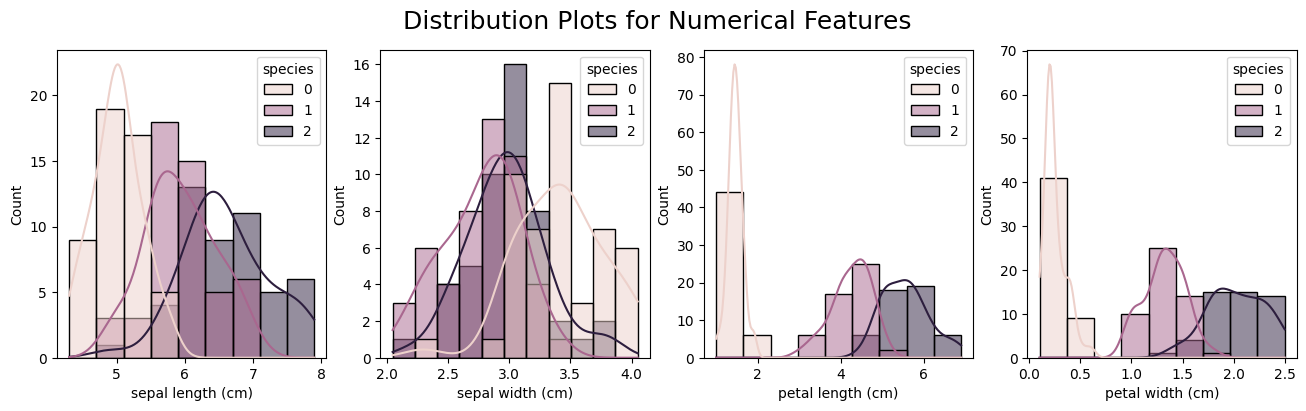

In [144]:
plot_distribution(df_cap, features, hue='species', figsize=(16, 4))

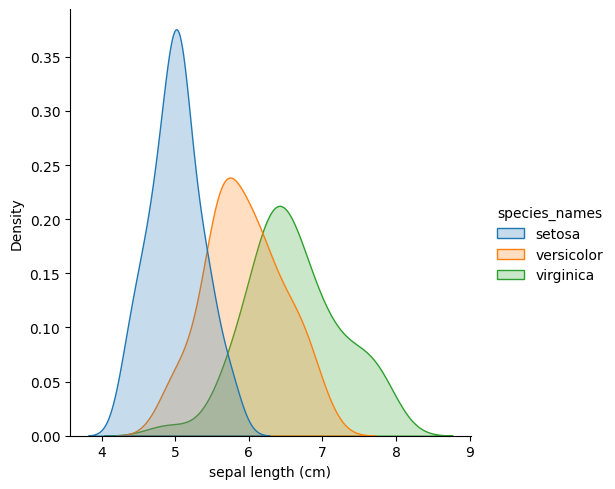

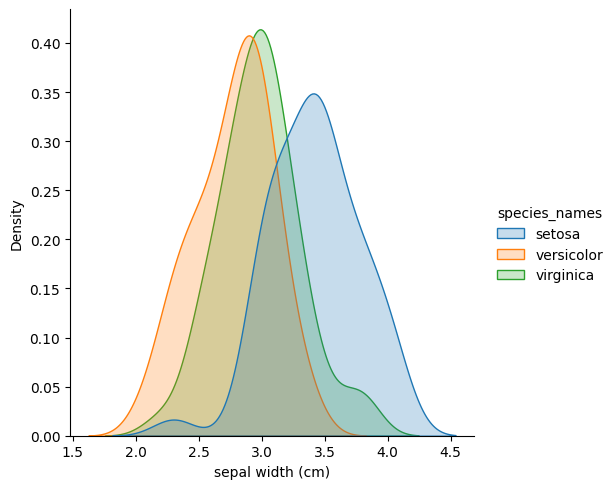

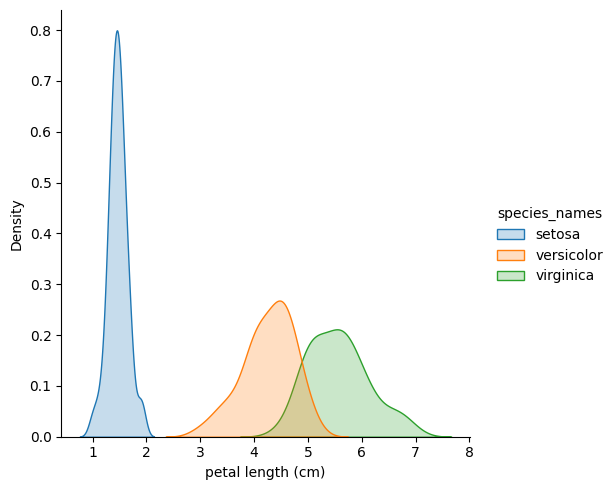

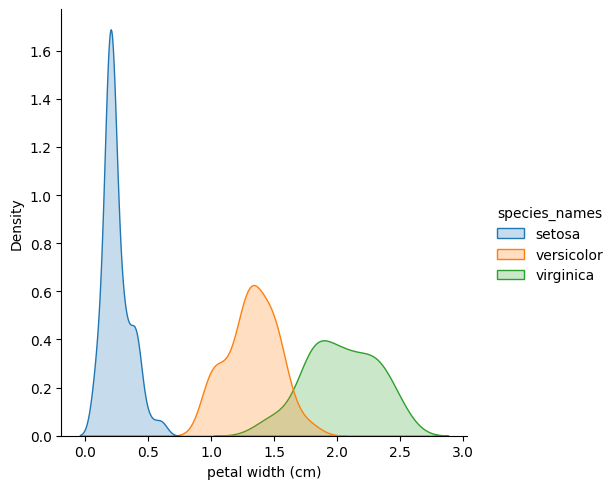

In [145]:
# Distribution Plots for each feature
for feature in iris.feature_names:
    sns.displot(df_cap, x=feature, hue="species_names", kind="kde", fill=True)
plt.show()

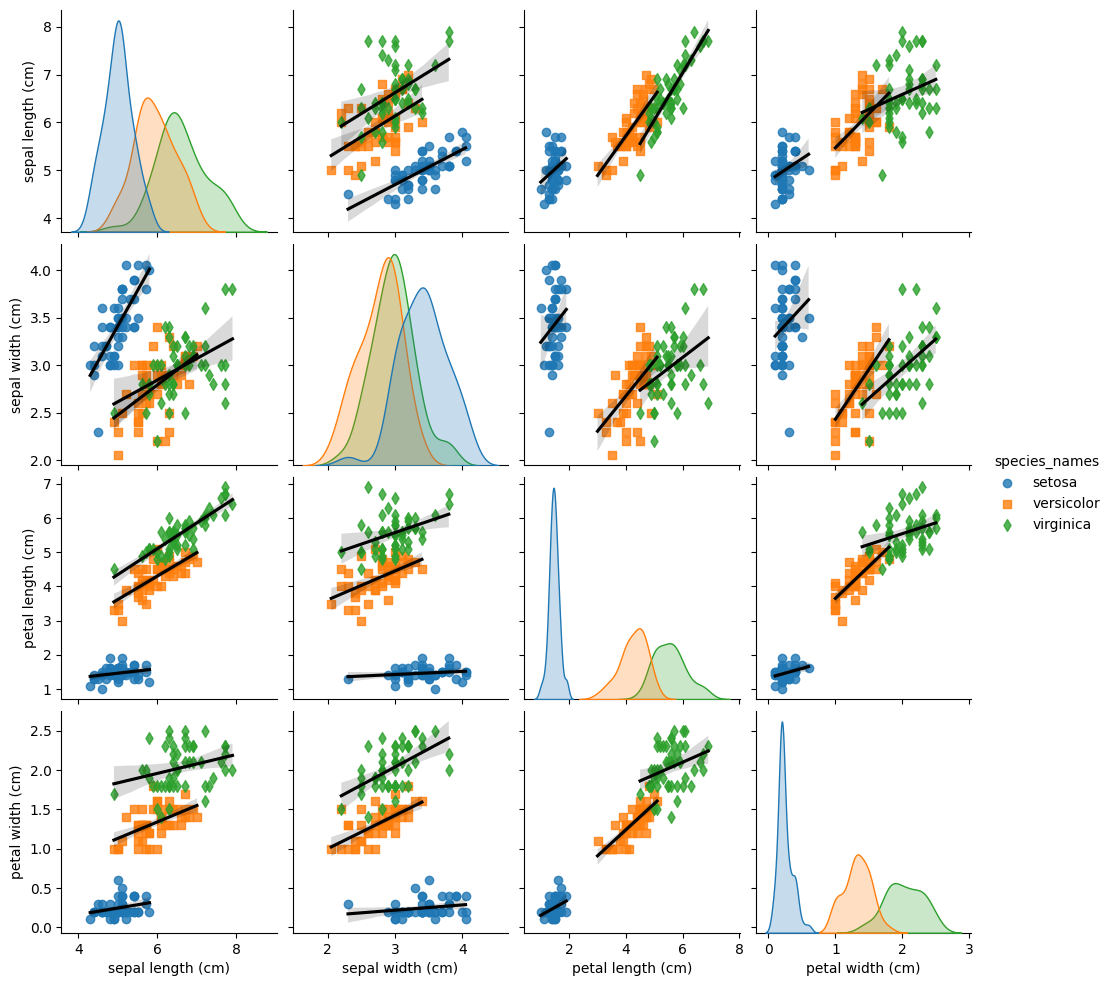

In [150]:
# Pairplot to observe the relationships between features
sns.pairplot(df_cap[features + ["species_names"]],kind="reg", hue="species_names", markers=["o","s","d"], plot_kws={"line_kws": {"color": "black"}})
plt.show()

**Scaling**

In [153]:
scaler = MinMaxScaler()
df_scaled = copy.deepcopy(df_cap)
df_scaled[features] = scaler.fit_transform(df_scaled[features])

In [157]:
df_scaled.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
count,149.000000,149.000000,149.000000,149.000000,149.000000
mean,0.428784,0.503188,0.465931,0.456096,0.993289
std,0.230792,0.212913,0.299626,0.317759,0.817847
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.222222,0.375000,0.101695,0.083333,0.000000
50%,0.416667,0.475000,0.559322,0.500000,1.000000
75%,0.583333,0.625000,0.694915,0.708333,2.000000
max,1.000000,1.000000,1.000000,1.000000,2.000000


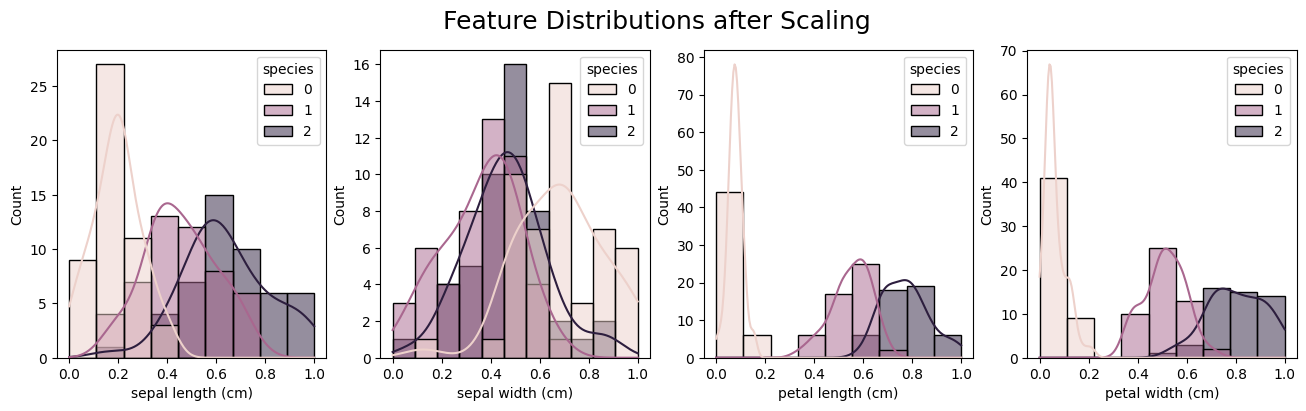

In [158]:
plot_distribution(df_scaled, features, hue='species', figsize=(16, 4), title='Feature Distributions after Scaling')

**Correlations:**

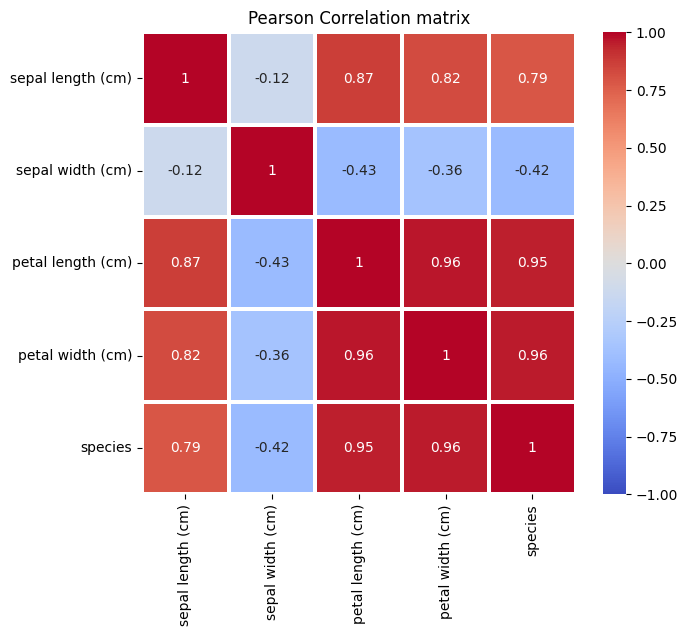

In [160]:
# Pearson correlation matrix
corr_matrix_pear = df_scaled[numerical].corr(method='pearson')
fig, ax = plt.subplots(figsize=(7,6))
sns.heatmap(corr_matrix_pear, vmin=-1, vmax=1, linewidths=1.5, annot=True, cmap=sns.color_palette("coolwarm", as_cmap=True))
plt.title("Pearson Correlation matrix")
plt.show()

Summary of EDA:

- There are 150 rows in the dataset with 4 features (float values)
- The target variable (species) has 3 unique values: 'setosa', 'versicolor', 'virginica'
- The target variable is well balanced, with 1/3 weights for all values
- There are no missing values in the dataset
- There are no physically meaningless values or erroneous data in the dataset (no need for imputation)
- There are 1 duplicates
- There are 4 outliers in 'sepal width'

# 2. Data Preparation with Pipeline

In the EDA chapter, we discovered our data and concluded the neccessary data preparation steps for our goals. As we mentioned in the EDA section, the real data preparation is performed in this chapter using a pipeline.

Before any data preparation, we need to perform the test-train split of our data, because we want to avoid data leakage (leak information from the future into the past). Scaling, transforming features, filling NaNs and handling outliers must be done after train-test split.

Now we go through the previously analyzed preparation steps, but the transformations for the test data will be performed based on the train for avoiding data leakage.

Data preparation strategy in the pipeline function:

1. **Drop Duplicates**: The data cleaning step only includes the "drop duplicate" part this time, therefore we perform it before train-test split.
2. **Train-Test Split**: The next step is the train-test split, which is good practice to avoid data leakage. The code correctly applies the train_test_split function. We split the data in such a manner that 70% of the data will be in the train dataset, and the rest 30% will be the test dataset (they are randomly splitted).
3. **Handling Outliers (Capping)**: We will limit the outliers rather than remove them because we want to keep their records data while reducing their impact. Outlier handling is done using the `cap_outliers` function. The threshold is calculated on the training dataset and then applied to both the training and test datasets. This ensures proper data leakage avoidance.
4. **Scaling (MinMaxScaler)**: Scaling is performed using the MinMaxScaler, and it is applied to both datasets. Importantly, the learned parameters from the training dataset are used for standardization on the test dataset as well.
5. **Creating PyTorch DataLoaders:** Finally, PyTorch DataLoaders are created for the training and test datasets.

Based on this analysis, the `data_pipeline` function correctly implements the train-test split and appropriately handles outliers and scaling method without encountering data leakage issues. The code is well-structured and easy to understand.

In [286]:
# Data pipeline for reading, preprocessing and preparing torch dataloaders
def data_pipeline(target_variable='species', batch_size=32, test_size=0.3, random_state=23, verbose=False, output='dataloader'):
    """
    Data pipeline for reading, preprocessing, and preparing PyTorch dataloaders.

    Parameters:
    - target_variable (str, optional): The target variable column name. Default is 'species'.
    - batch_size (int, optional): The batch size for dataloaders. Default is 32.
    - test_size (float, optional): The proportion of the dataset to include in the test split. Default is 0.3.
    - random_state (int, optional): Seed for reproducibility. Default is 23.
    - verbose (bool, optional): If True, print detailed information about the loaded dataset. Default is False.
    - output (str, optional): Desired output format ('df', 'train-test', 'xy', 'dataloader'). Default is 'dataloader'.

    Returns:
    - Depending on the 'output' parameter:
      - If 'output' is 'df' or 'dataframe', returns the original DataFrame.
      - If 'output' is 'train-test', returns the training and test DataFrames.
      - If 'output' is 'xy', returns the predictor features and target variables for training and test sets.
      - If 'output' is 'dataloader', returns PyTorch DataLoader objects for training and test sets.

    Examples:
    train_dataloader, validation_dataloader = data_pipeline(output='dataloader', batch_size=32, verbose=True)
    """
    
    test_size = test_size
    random_state = random_state

    # load data
    iris = datasets.load_iris()
    df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
    df[target_variable] = iris.target
    
    col_names = list(df.columns)
    features = iris.feature_names

    # clean data (drop duplicates)
    num_duplicates = (df.duplicated() == True).sum()
    df_clean = df.drop_duplicates()

    # train-test split (before any data preparation in order to avoid data leakage)
    train, test = train_test_split(df_clean, test_size=test_size, random_state=random_state)

    # Handling Outliers (Capping method)
    # determining the lower and upper bounds of outliers based on the train data 
    # and apply these to the test data as well in order to avoid data leakage.
    train_cap, test_cap = cap_outliers(train, features, test_data=test, threshold=1.5)

    # Scaling (MinMaxScaler)
    scaler = MinMaxScaler()
    train_scaled = copy.deepcopy(train_cap)
    test_scaled = copy.deepcopy(test_cap)
    train_scaled[features] = scaler.fit_transform(train_scaled[features])
    test_scaled[features] = scaler.transform(test_scaled[features])

    # Separation of the target variable from the predictior features
    X_train, y_train = train_scaled.drop(target_variable, axis=1), train_scaled[target_variable]
    X_test, y_test = test_scaled.drop(target_variable, axis=1), test_scaled[target_variable]

    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
    X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)  
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)


    # Create DataLoader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
    
    if verbose:
        print(f"Loaded Dataset:\n{df.head()}\n")
        print(f"Number of rows in dataset: {df.shape[0]}")
        print(f"Number of columns in dataset: {df.shape[1]}")
        print(f"Missing values: {df.isna().sum().sum()}")
        print(f"column names: {col_names}")
        print(f"features: {features}")
        print(f"Number of duplicates: {num_duplicates}")
        print(f"Number of rows in dataset after drop duplicates: {df_clean.shape[0]}")
        print(f"Number of rows in train dataset: {len(train)} ({round(100*len(train)/len(df_clean),1)} %)")
        print(f"Number of rows in test dataset: {len(test)} ({round(100*len(test)/len(df_clean),1)} %)")
        print(f'batch={batch_size}\n')

    if output.lower() in ('df', 'dataframe'):
        return df
    elif output.lower() == 'train-test':
        return train, test
    elif output.lower() == 'xy':
        return X_train, y_train, X_test, y_test
    elif output.lower() == 'dataloader':
        return train_loader, test_loader
    else:
        print('wrong output')


**Checking the distributions of the train and test data:**

In [238]:
X_train, y_train, X_test, y_test = data_pipeline(output='Xy', verbose=True)

Loaded Dataset:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  species
0                5.1               3.5                1.4               0.2        0
1                4.9               3.0                1.4               0.2        0
2                4.7               3.2                1.3               0.2        0
3                4.6               3.1                1.5               0.2        0
4                5.0               3.6                1.4               0.2        0

Number of rows in dataset: 150
Number of columns in dataset: 5
Missing values: 0
column names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)', 'species']
features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Number of duplicates: 1
Number of rows in dataset after drop duplicates: 149
Number of rows in train dataset: 104 (69.8 %)
Number of rows in test dataset: 45 (30.2 %)


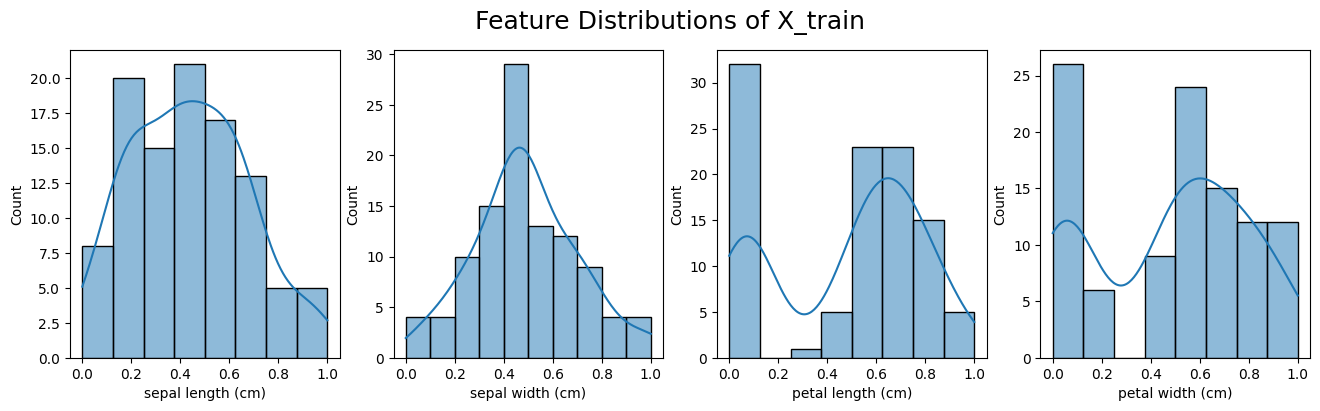

In [246]:
plot_distribution(X_train, features, figsize=(16, 4), title='Feature Distributions of X_train')

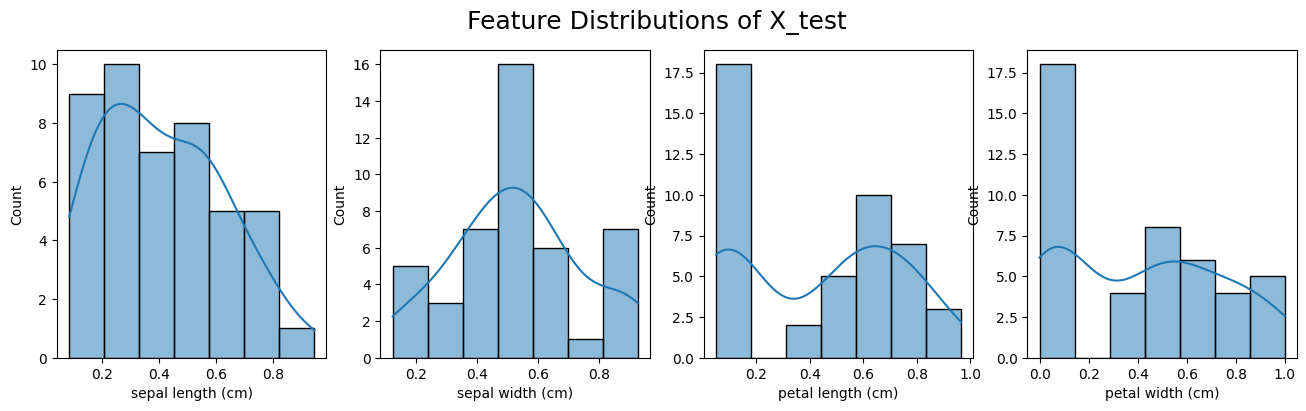

In [240]:
plot_distribution(X_test, features, figsize=(16, 4), title='Feature Distributions of X_test')

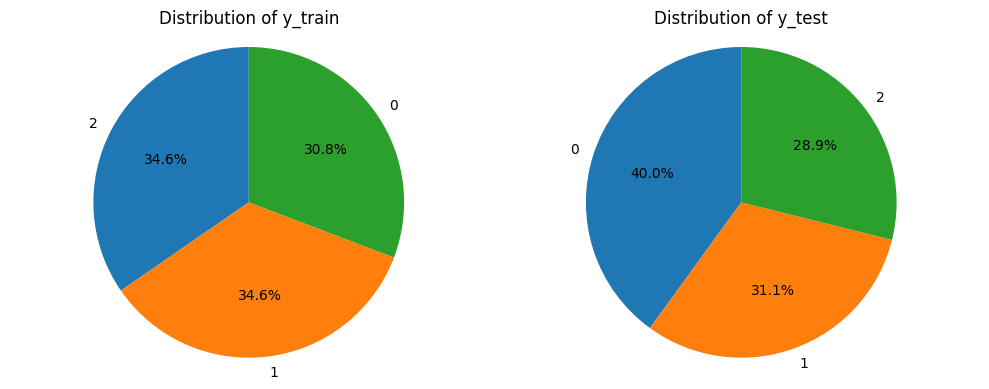

In [253]:
# pie chart for target variable
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Pie chart train
axes[0].pie(y_train.value_counts(), labels=y_train.value_counts().index, autopct='%1.1f%%', startangle=90, )
axes[0].axis('equal')
axes[0].set_title(f'Distribution of y_train')

# Pie chart test
axes[1].pie(y_test.value_counts(), labels=y_test.value_counts().index, autopct='%1.1f%%', startangle=90, )
axes[1].axis('equal')
axes[1].set_title(f'Distribution of y_test')

plt.tight_layout()
plt.show()

# 3. Neural Network training with PyTorch

We will be using two models in our code. SimpleNN is a more straightforward model, while ComplexNN incorporates multiple layers and a more intricate structure with batch normalization and dropout layers. Both models apply the Softmax activation function at the output layer, suitable for the classification task.

1. **SimpleNN:**
   - SimpleNN is designed for simplicity, featuring a single hidden layer.
   - Architecture: Input layer (4 features) → Hidden layer (10 neurons, ReLU activation) → Output layer (3 classes, Softmax activation).

2. **ComplexNN:**
   - ComplexNN is a more sophisticated model with two hidden layers, utilizing batch normalization and dropout for regularization.
   - Architecture: Input layer (4 features) → Hidden layer 1 (64 neurons, BatchNorm, Dropout, ReLU activation) → Hidden layer 2 (32 neurons, BatchNorm, Dropout, ReLU activation) → Output layer (3 classes, Softmax activation).

In [262]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(4, 10)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(10, 3)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x


class ComplexNN(nn.Module):
    def __init__(self):
        super(ComplexNN, self).__init__()
        self.fc1 = nn.Linear(4, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.dropout1 = nn.Dropout(0.5)
        self.relu1 = nn.ReLU()

        self.fc2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32)
        self.dropout2 = nn.Dropout(0.3)
        self.relu2 = nn.ReLU()

        self.fc3 = nn.Linear(32, 3)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.dropout1(x)
        x = self.relu1(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.dropout2(x)
        x = self.relu2(x)

        x = self.fc3(x)
        x = self.softmax(x)

        return x

In [284]:
def train_and_evaluate_model(model, train_dataloader, validation_dataloader, epochs, lr, model_name, verbose=0):
    """
    Train and evaluate a PyTorch model using the specified training and validation dataloaders.

    Parameters:
    - model (nn.Module): The PyTorch model to be trained and evaluated.
    - train_dataloader (DataLoader): Dataloader for the training dataset.
    - validation_dataloader (DataLoader): Dataloader for the validation dataset.
    - epochs (int): Number of training epochs.
    - lr (float): Learning rate for the optimizer.
    - model_name (str): Name or description of the model, used in the learning curve plot.
    - verbose (int, optional): If greater than 0, print the average training loss every 'verbose' epochs. Default is 0.

    Returns:
    - model (nn.Module): Trained PyTorch model.
    
    The function performs model training using the specified optimizer and loss function (CrossEntropyLoss for classification).
    It prints the average training loss at specified intervals and plots the learning curve.
    The model is trained for the specified number of epochs and returned.
    """
    
    #device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    device = torch.device("cpu")
    model.to(device)

    # CrossEntropyLoss for multi-class classification
    criterion = nn.CrossEntropyLoss() 
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0

        for inputs, labels in train_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        average_loss = total_loss / len(train_dataloader)
        train_losses.append(average_loss)

        if verbose and epoch % verbose == 0:
            print(f'Epoch {epoch+1}/{epochs}, Average Loss: {average_loss}')

        # Validation loss
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for inputs, labels in validation_dataloader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()

        average_val_loss = val_loss / len(validation_dataloader)
        val_losses.append(average_val_loss)

    # Plotting the learning curve
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Learning Curve - {model_name}')
    plt.legend()
    plt.ylim(0, max(max(train_losses), 1.2*max(val_losses)))
    plt.show()

    return model

In [285]:
def evaluate_model(model, validation_dataloader):
    """
    Evaluate a PyTorch model on the validation dataset.

    Parameters:
    - model (nn.Module): The PyTorch model to be evaluated.
    - validation_dataloader (DataLoader): Dataloader for the validation dataset.

    Prints:
    - Validation accuracy.
    - Classification report.

    The function evaluates the model on the validation dataset, calculating accuracy and printing the classification report.
    """
    
    #device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    device = torch.device("cpu")
    model.eval()
    total_correct = 0
    total_samples = 0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for inputs, labels in validation_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)  # Use torch.max to get the predicted class indices

            total_correct += (predictions == labels).sum().item()
            total_samples += labels.size(0)

            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())

    accuracy = total_correct / total_samples
    print(f"Validation Accuracy: {accuracy * 100:.2f}%")

    # Print the classification report
    print("Classification Report:")
    print(classification_report(all_targets, all_predictions))


## **Simple Neural Network Model**

**Batch Size**

**_batch_size=1_**

Using only one sample of data on every iteration to compute the loss is called "Stochastic Gradient Descent."

Loaded Dataset:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  species
0                5.1               3.5                1.4               0.2        0
1                4.9               3.0                1.4               0.2        0
2                4.7               3.2                1.3               0.2        0
3                4.6               3.1                1.5               0.2        0
4                5.0               3.6                1.4               0.2        0

Number of rows in dataset: 150
Number of columns in dataset: 5
Missing values: 0
column names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)', 'species']
features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Number of duplicates: 1
Number of rows in dataset after drop duplicates: 149
Number of rows in train dataset: 104 (69.8 %)
Number of rows in test dataset: 45 (30.2 %)
batch=1

Epoch 1/100, Av

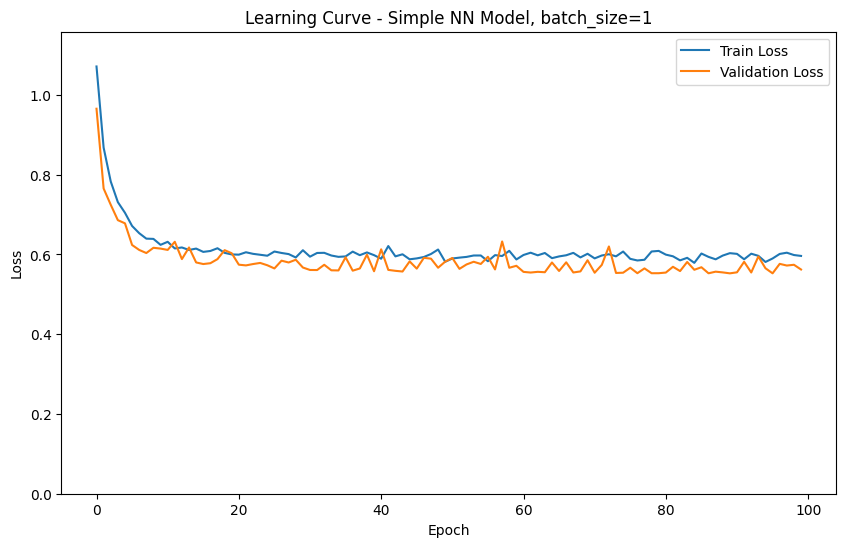

Validation Accuracy: 100.00%
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        13

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45



In [306]:
train_dataloader, validation_dataloader = data_pipeline(output='dataloader', batch_size=1, verbose=True)

simple_model = SimpleNN() 

simple_trained_model = train_and_evaluate_model(
                        simple_model, 
                        train_dataloader, 
                        validation_dataloader, 
                        epochs=100, 
                        lr=0.01,
                        verbose=10,
                        model_name="Simple NN Model, batch_size=1"
)

evaluate_model(simple_trained_model, validation_dataloader)

**_batch_size = entire training set_**

Using all the data at once is called "Batch Gradient Descent."

Loaded Dataset:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  species
0                5.1               3.5                1.4               0.2        0
1                4.9               3.0                1.4               0.2        0
2                4.7               3.2                1.3               0.2        0
3                4.6               3.1                1.5               0.2        0
4                5.0               3.6                1.4               0.2        0

Number of rows in dataset: 150
Number of columns in dataset: 5
Missing values: 0
column names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)', 'species']
features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Number of duplicates: 1
Number of rows in dataset after drop duplicates: 149
Number of rows in train dataset: 104 (69.8 %)
Number of rows in test dataset: 45 (30.2 %)
batch=104

Epoch 1/500, 

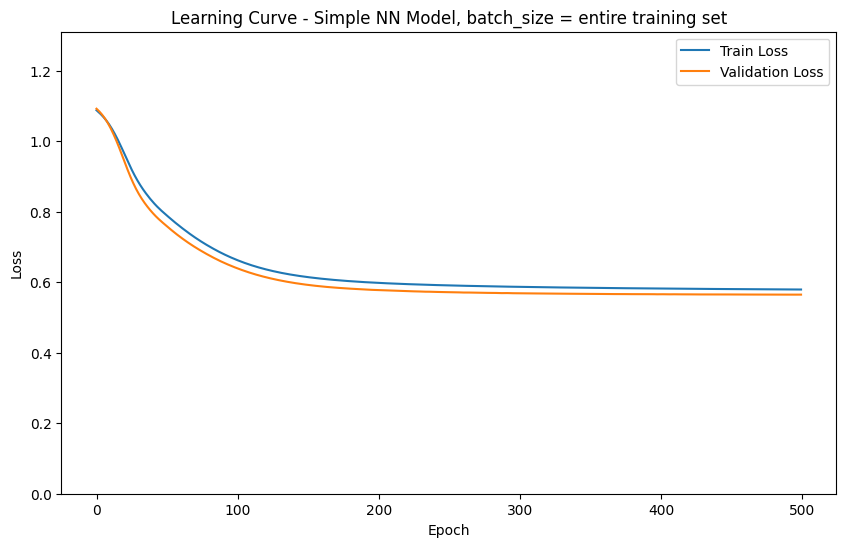

Validation Accuracy: 100.00%
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        13

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45



In [307]:
train_dataloader, validation_dataloader = data_pipeline(output='dataloader', batch_size=(len(X_train)), verbose=True)

simple_model = SimpleNN() 

simple_trained_model = train_and_evaluate_model(
                        simple_model, 
                        train_dataloader, 
                        validation_dataloader, 
                        epochs=500, 
                        lr=0.01,
                        verbose=20,
                        model_name="Simple NN Model, batch_size = entire training set"
)

evaluate_model(simple_trained_model, validation_dataloader)

**_batch_size=32_**

Using some data, more than one sample but fewer than the entire training set is called "Mini-Batch Gradient Descent." 

Loaded Dataset:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  species
0                5.1               3.5                1.4               0.2        0
1                4.9               3.0                1.4               0.2        0
2                4.7               3.2                1.3               0.2        0
3                4.6               3.1                1.5               0.2        0
4                5.0               3.6                1.4               0.2        0

Number of rows in dataset: 150
Number of columns in dataset: 5
Missing values: 0
column names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)', 'species']
features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Number of duplicates: 1
Number of rows in dataset after drop duplicates: 149
Number of rows in train dataset: 104 (69.8 %)
Number of rows in test dataset: 45 (30.2 %)
batch=32

Epoch 1/1000, 

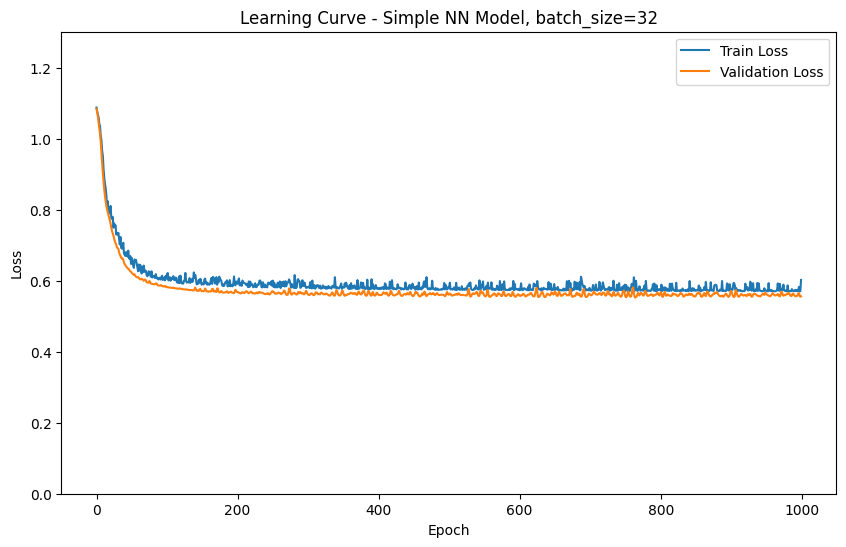

Validation Accuracy: 100.00%
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        13

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45



In [308]:
train_dataloader, validation_dataloader = data_pipeline(output='dataloader', batch_size=32, verbose=True)

simple_model = SimpleNN() 

simple_trained_model = train_and_evaluate_model(
                        simple_model, 
                        train_dataloader, 
                        validation_dataloader, 
                        epochs=1000, 
                        lr=0.01,
                        verbose=100,
                        model_name="Simple NN Model, batch_size=32"
)

evaluate_model(simple_trained_model, validation_dataloader)

**_Different Learning Rates_**

Loaded Dataset:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  species
0                5.1               3.5                1.4               0.2        0
1                4.9               3.0                1.4               0.2        0
2                4.7               3.2                1.3               0.2        0
3                4.6               3.1                1.5               0.2        0
4                5.0               3.6                1.4               0.2        0

Number of rows in dataset: 150
Number of columns in dataset: 5
Missing values: 0
column names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)', 'species']
features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Number of duplicates: 1
Number of rows in dataset after drop duplicates: 149
Number of rows in train dataset: 104 (69.8 %)
Number of rows in test dataset: 45 (30.2 %)
batch=32

Epoch 1/1000, 

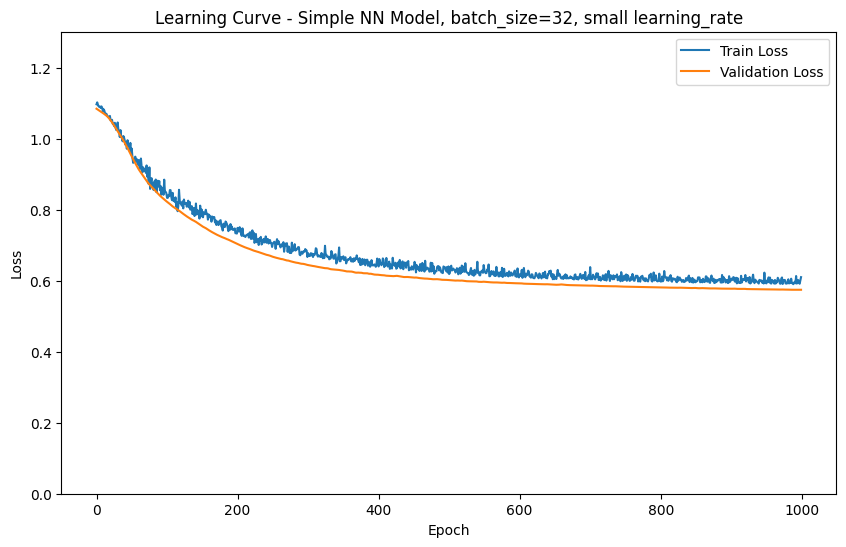

Validation Accuracy: 100.00%
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        13

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45



In [330]:
train_dataloader, validation_dataloader = data_pipeline(output='dataloader', batch_size=32, verbose=True)

simple_model = SimpleNN() 

simple_trained_model = train_and_evaluate_model(
                        simple_model, 
                        train_dataloader, 
                        validation_dataloader, 
                        epochs=1000, 
                        lr=0.001,
                        verbose=100,
                        model_name="Simple NN Model, batch_size=32, small learning_rate"
)

evaluate_model(simple_trained_model, validation_dataloader)

Loaded Dataset:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  species
0                5.1               3.5                1.4               0.2        0
1                4.9               3.0                1.4               0.2        0
2                4.7               3.2                1.3               0.2        0
3                4.6               3.1                1.5               0.2        0
4                5.0               3.6                1.4               0.2        0

Number of rows in dataset: 150
Number of columns in dataset: 5
Missing values: 0
column names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)', 'species']
features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Number of duplicates: 1
Number of rows in dataset after drop duplicates: 149
Number of rows in train dataset: 104 (69.8 %)
Number of rows in test dataset: 45 (30.2 %)
batch=32

Epoch 1/1000, 

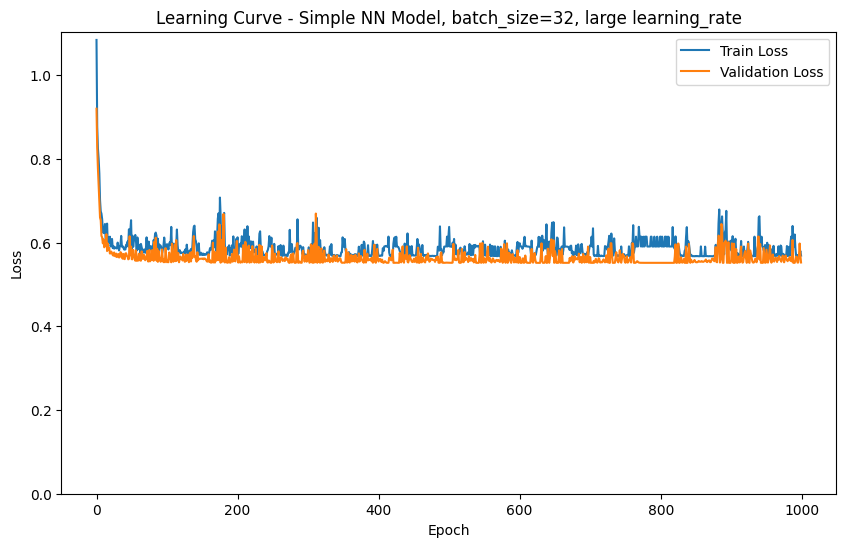

Validation Accuracy: 100.00%
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        13

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45



In [331]:
train_dataloader, validation_dataloader = data_pipeline(output='dataloader', batch_size=32, verbose=True)

simple_model = SimpleNN() 

simple_trained_model = train_and_evaluate_model(
                        simple_model, 
                        train_dataloader, 
                        validation_dataloader, 
                        epochs=1000, 
                        lr=0.1,
                        verbose=100,
                        model_name="Simple NN Model, batch_size=32, large learning_rate"
)

evaluate_model(simple_trained_model, validation_dataloader)

**Test Size**

**test_size=0.5**

Loaded Dataset:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  species
0                5.1               3.5                1.4               0.2        0
1                4.9               3.0                1.4               0.2        0
2                4.7               3.2                1.3               0.2        0
3                4.6               3.1                1.5               0.2        0
4                5.0               3.6                1.4               0.2        0

Number of rows in dataset: 150
Number of columns in dataset: 5
Missing values: 0
column names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)', 'species']
features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Number of duplicates: 1
Number of rows in dataset after drop duplicates: 149
Number of rows in train dataset: 74 (49.7 %)
Number of rows in test dataset: 75 (50.3 %)
batch=32

Epoch 1/1000, A

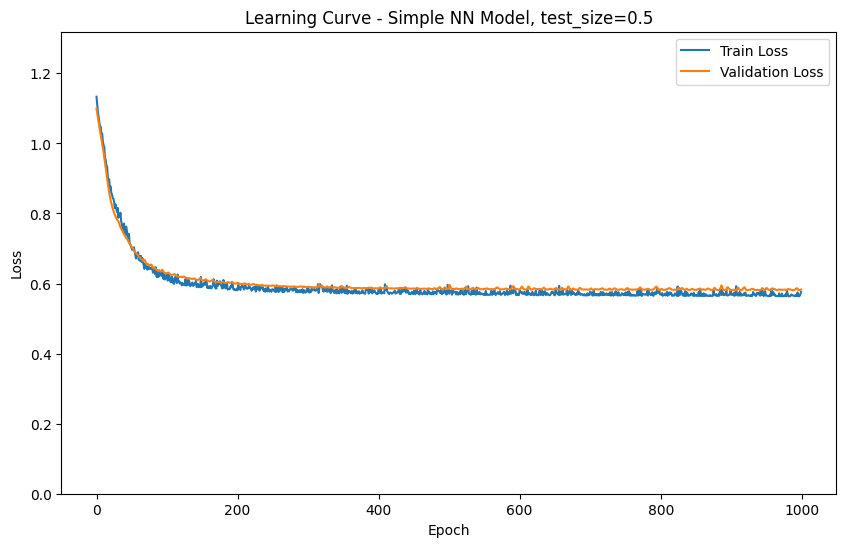

Validation Accuracy: 96.00%
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       0.88      1.00      0.94        23
           2       1.00      0.88      0.94        25

    accuracy                           0.96        75
   macro avg       0.96      0.96      0.96        75
weighted avg       0.96      0.96      0.96        75



In [341]:
train_dataloader, validation_dataloader = data_pipeline(output='dataloader', batch_size=32, verbose=True, test_size=0.5)

simple_model = SimpleNN() 

simple_trained_model = train_and_evaluate_model(
                        simple_model, 
                        train_dataloader, 
                        validation_dataloader, 
                        epochs=1000, 
                        lr=0.01,
                        verbose=100,
                        model_name="Simple NN Model, test_size=0.5"
)

evaluate_model(simple_trained_model, validation_dataloader)

**test_size=0.9**

Loaded Dataset:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  species
0                5.1               3.5                1.4               0.2        0
1                4.9               3.0                1.4               0.2        0
2                4.7               3.2                1.3               0.2        0
3                4.6               3.1                1.5               0.2        0
4                5.0               3.6                1.4               0.2        0

Number of rows in dataset: 150
Number of columns in dataset: 5
Missing values: 0
column names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)', 'species']
features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Number of duplicates: 1
Number of rows in dataset after drop duplicates: 149
Number of rows in train dataset: 14 (9.4 %)
Number of rows in test dataset: 135 (90.6 %)
batch=32

Epoch 1/1000, A

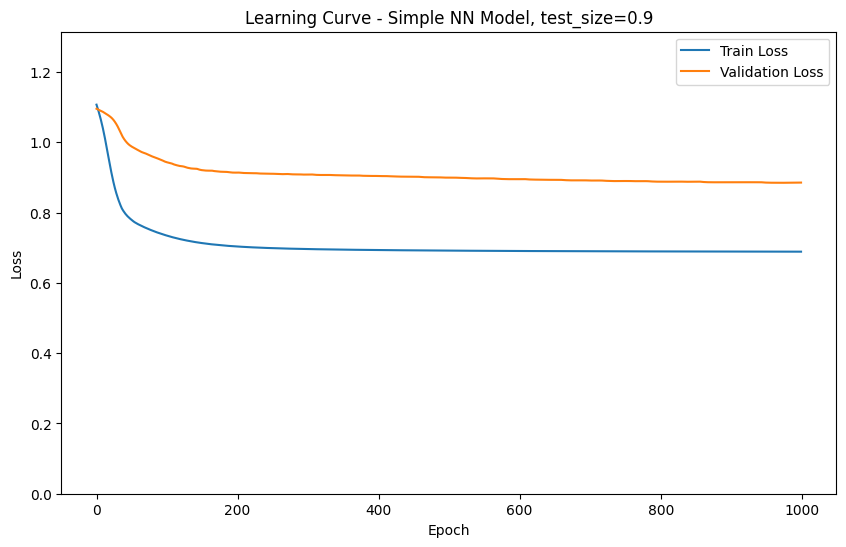

Validation Accuracy: 64.44%
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        41
           1       0.49      0.98      0.66        47
           2       0.00      0.00      0.00        47

    accuracy                           0.64       135
   macro avg       0.49      0.66      0.55       135
weighted avg       0.47      0.64      0.53       135



In [342]:
train_dataloader, validation_dataloader = data_pipeline(output='dataloader', batch_size=32, verbose=True, test_size=0.9)

simple_model = SimpleNN() 

simple_trained_model = train_and_evaluate_model(
                        simple_model, 
                        train_dataloader, 
                        validation_dataloader, 
                        epochs=1000, 
                        lr=0.01,
                        verbose=100,
                        model_name="Simple NN Model, test_size=0.9"
)

evaluate_model(simple_trained_model, validation_dataloader)

**test_size=0.95**

Loaded Dataset:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  species
0                5.1               3.5                1.4               0.2        0
1                4.9               3.0                1.4               0.2        0
2                4.7               3.2                1.3               0.2        0
3                4.6               3.1                1.5               0.2        0
4                5.0               3.6                1.4               0.2        0

Number of rows in dataset: 150
Number of columns in dataset: 5
Missing values: 0
column names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)', 'species']
features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Number of duplicates: 1
Number of rows in dataset after drop duplicates: 149
Number of rows in train dataset: 7 (4.7 %)
Number of rows in test dataset: 142 (95.3 %)
batch=32

Epoch 1/1000, Av

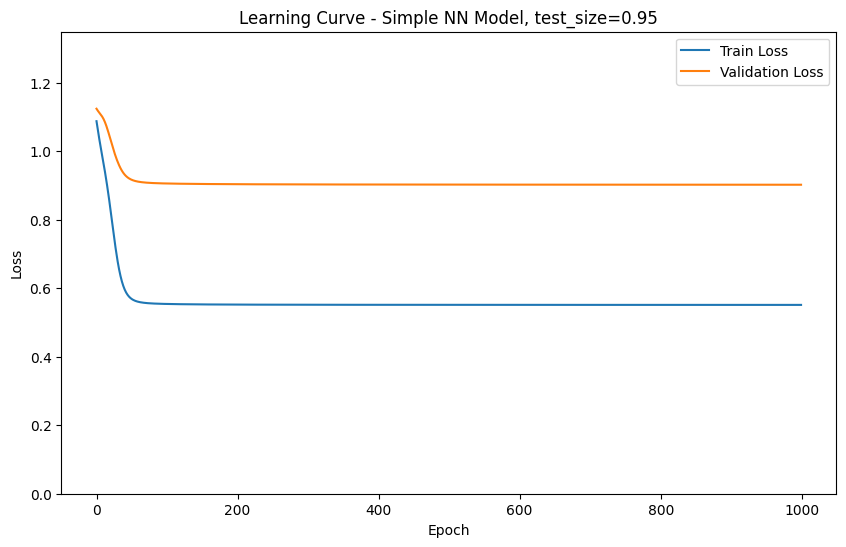

Validation Accuracy: 65.49%
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        46
           1       0.49      1.00      0.66        47
           2       0.00      0.00      0.00        49

    accuracy                           0.65       142
   macro avg       0.50      0.67      0.55       142
weighted avg       0.49      0.65      0.54       142



In [343]:
train_dataloader, validation_dataloader = data_pipeline(output='dataloader', batch_size=32, verbose=True, test_size=0.95)

simple_model = SimpleNN() 

simple_trained_model = train_and_evaluate_model(
                        simple_model, 
                        train_dataloader, 
                        validation_dataloader, 
                        epochs=1000, 
                        lr=0.01,
                        verbose=100,
                        model_name="Simple NN Model, test_size=0.95"
)

evaluate_model(simple_trained_model, validation_dataloader)

## Complex Neural Network Model

**_batch_size=2_**

Loaded Dataset:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  species
0                5.1               3.5                1.4               0.2        0
1                4.9               3.0                1.4               0.2        0
2                4.7               3.2                1.3               0.2        0
3                4.6               3.1                1.5               0.2        0
4                5.0               3.6                1.4               0.2        0

Number of rows in dataset: 150
Number of columns in dataset: 5
Missing values: 0
column names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)', 'species']
features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Number of duplicates: 1
Number of rows in dataset after drop duplicates: 149
Number of rows in train dataset: 104 (69.8 %)
Number of rows in test dataset: 45 (30.2 %)
batch=2

Epoch 1/100, Av

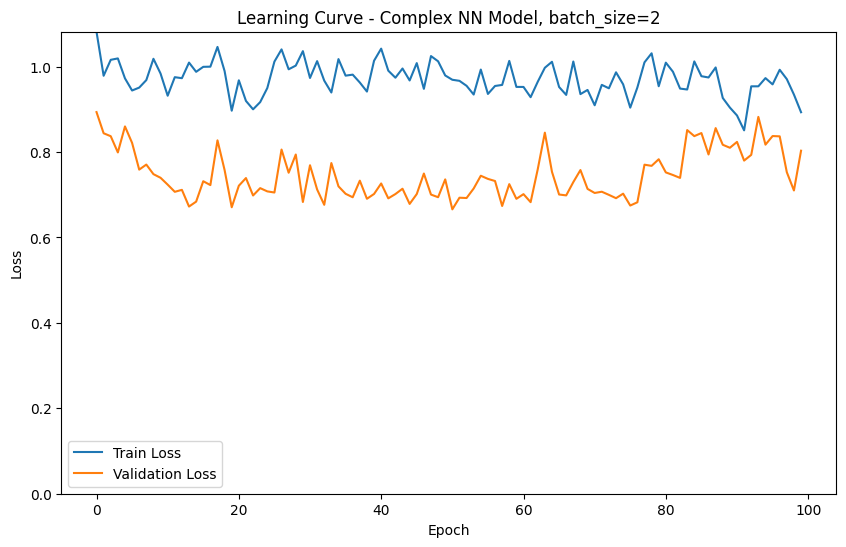

Validation Accuracy: 73.33%
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      0.14      0.25        14
           2       0.52      1.00      0.68        13

    accuracy                           0.73        45
   macro avg       0.84      0.71      0.64        45
weighted avg       0.86      0.73      0.68        45



In [314]:
train_dataloader, validation_dataloader = data_pipeline(output='dataloader', batch_size=2, verbose=True)

simple_model = ComplexNN() 

simple_trained_model = train_and_evaluate_model(
                        simple_model, 
                        train_dataloader, 
                        validation_dataloader, 
                        epochs=100, 
                        lr=0.01,
                        verbose=10,
                        model_name="Complex NN Model, batch_size=2"
)

evaluate_model(simple_trained_model, validation_dataloader)

**_batch_size = entire training set_**

Loaded Dataset:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  species
0                5.1               3.5                1.4               0.2        0
1                4.9               3.0                1.4               0.2        0
2                4.7               3.2                1.3               0.2        0
3                4.6               3.1                1.5               0.2        0
4                5.0               3.6                1.4               0.2        0

Number of rows in dataset: 150
Number of columns in dataset: 5
Missing values: 0
column names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)', 'species']
features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Number of duplicates: 1
Number of rows in dataset after drop duplicates: 149
Number of rows in train dataset: 104 (69.8 %)
Number of rows in test dataset: 45 (30.2 %)
batch=104

Epoch 1/100, 

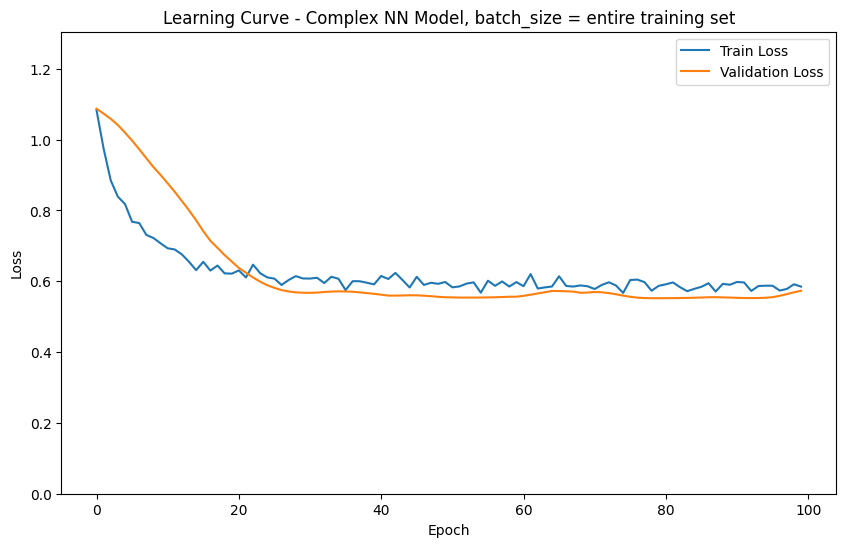

Validation Accuracy: 97.78%
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       0.93      1.00      0.97        14
           2       1.00      0.92      0.96        13

    accuracy                           0.98        45
   macro avg       0.98      0.97      0.98        45
weighted avg       0.98      0.98      0.98        45



In [315]:
train_dataloader, validation_dataloader = data_pipeline(output='dataloader', batch_size=len(X_train), verbose=True)

simple_model = ComplexNN() 

simple_trained_model = train_and_evaluate_model(
                        simple_model, 
                        train_dataloader, 
                        validation_dataloader, 
                        epochs=100, 
                        lr=0.01,
                        verbose=10,
                        model_name="Complex NN Model, batch_size = entire training set"
)

evaluate_model(simple_trained_model, validation_dataloader)

**_batch_size=32_**

Loaded Dataset:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  species
0                5.1               3.5                1.4               0.2        0
1                4.9               3.0                1.4               0.2        0
2                4.7               3.2                1.3               0.2        0
3                4.6               3.1                1.5               0.2        0
4                5.0               3.6                1.4               0.2        0

Number of rows in dataset: 150
Number of columns in dataset: 5
Missing values: 0
column names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)', 'species']
features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Number of duplicates: 1
Number of rows in dataset after drop duplicates: 149
Number of rows in train dataset: 104 (69.8 %)
Number of rows in test dataset: 45 (30.2 %)
batch=32

Epoch 1/100, A

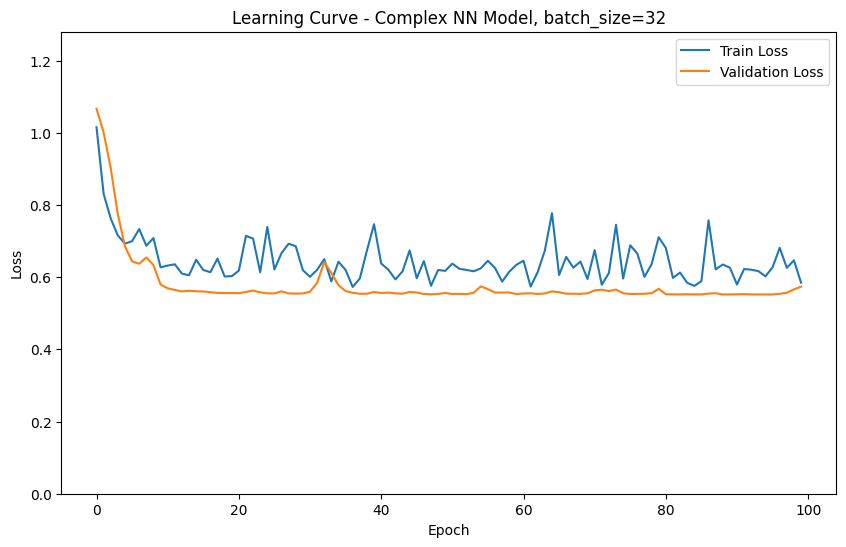

Validation Accuracy: 95.56%
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       0.88      1.00      0.93        14
           2       1.00      0.85      0.92        13

    accuracy                           0.96        45
   macro avg       0.96      0.95      0.95        45
weighted avg       0.96      0.96      0.96        45



In [311]:
train_dataloader, validation_dataloader = data_pipeline(output='dataloader', batch_size=32, verbose=True)

simple_model = ComplexNN() 

simple_trained_model = train_and_evaluate_model(
                        simple_model, 
                        train_dataloader, 
                        validation_dataloader, 
                        epochs=100, 
                        lr=0.01,
                        verbose=10,
                        model_name="Complex NN Model, batch_size=32"
)

evaluate_model(simple_trained_model, validation_dataloader)

# **Final Best Model**

**Checking Our Best Model with Different random_states**

Loaded Dataset:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  species
0                5.1               3.5                1.4               0.2        0
1                4.9               3.0                1.4               0.2        0
2                4.7               3.2                1.3               0.2        0
3                4.6               3.1                1.5               0.2        0
4                5.0               3.6                1.4               0.2        0

Number of rows in dataset: 150
Number of columns in dataset: 5
Missing values: 0
column names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)', 'species']
features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Number of duplicates: 1
Number of rows in dataset after drop duplicates: 149
Number of rows in train dataset: 104 (69.8 %)
Number of rows in test dataset: 45 (30.2 %)
batch=32

Epoch 1/1000, 

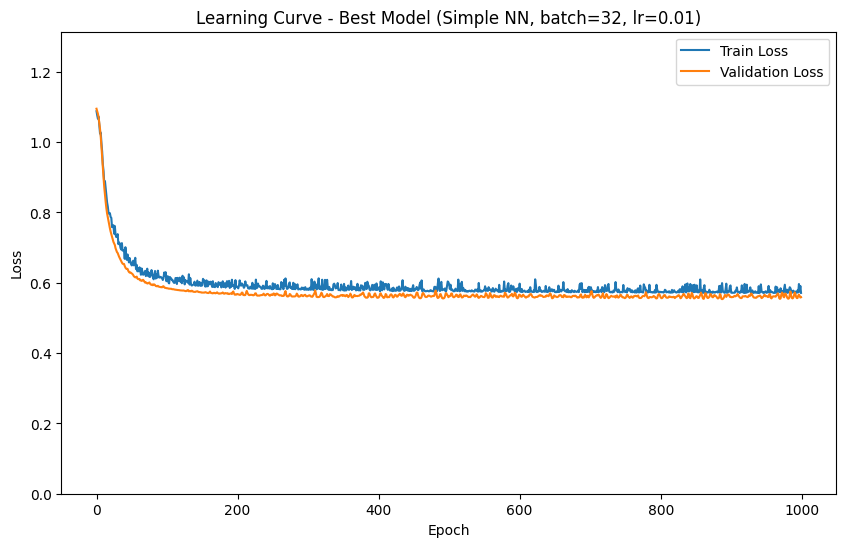

Validation Accuracy: 100.00%
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        13

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45



In [345]:
train_dataloader, validation_dataloader = data_pipeline(output='dataloader', batch_size=32, verbose=True, test_size=0.3, random_state=23)

simple_model = SimpleNN() 

simple_trained_model = train_and_evaluate_model(
                        simple_model, 
                        train_dataloader, 
                        validation_dataloader, 
                        epochs=1000, 
                        lr=0.01,
                        verbose=100,
                        model_name="Best Model (Simple NN, batch=32, lr=0.01)"
)

evaluate_model(simple_trained_model, validation_dataloader)

Loaded Dataset:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  species
0                5.1               3.5                1.4               0.2        0
1                4.9               3.0                1.4               0.2        0
2                4.7               3.2                1.3               0.2        0
3                4.6               3.1                1.5               0.2        0
4                5.0               3.6                1.4               0.2        0

Number of rows in dataset: 150
Number of columns in dataset: 5
Missing values: 0
column names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)', 'species']
features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Number of duplicates: 1
Number of rows in dataset after drop duplicates: 149
Number of rows in train dataset: 104 (69.8 %)
Number of rows in test dataset: 45 (30.2 %)
batch=32

Epoch 1/1000, 

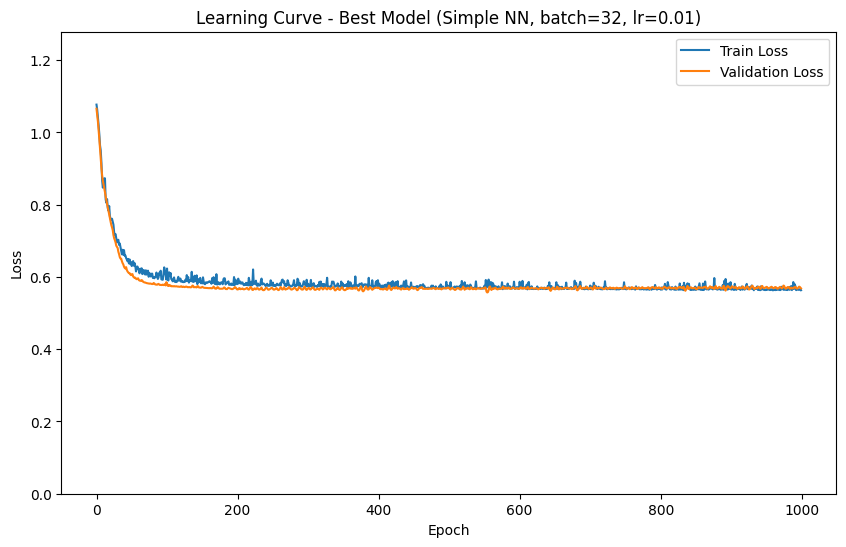

Validation Accuracy: 97.78%
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.94      1.00      0.97        16
           2       1.00      0.92      0.96        13

    accuracy                           0.98        45
   macro avg       0.98      0.97      0.98        45
weighted avg       0.98      0.98      0.98        45



In [346]:
train_dataloader, validation_dataloader = data_pipeline(output='dataloader', batch_size=32, verbose=True, test_size=0.3, random_state=0)

simple_model = SimpleNN() 

simple_trained_model = train_and_evaluate_model(
                        simple_model, 
                        train_dataloader, 
                        validation_dataloader, 
                        epochs=1000, 
                        lr=0.01,
                        verbose=100,
                        model_name="Best Model (Simple NN, batch=32, lr=0.01)"
)

evaluate_model(simple_trained_model, validation_dataloader)

Loaded Dataset:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  species
0                5.1               3.5                1.4               0.2        0
1                4.9               3.0                1.4               0.2        0
2                4.7               3.2                1.3               0.2        0
3                4.6               3.1                1.5               0.2        0
4                5.0               3.6                1.4               0.2        0

Number of rows in dataset: 150
Number of columns in dataset: 5
Missing values: 0
column names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)', 'species']
features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Number of duplicates: 1
Number of rows in dataset after drop duplicates: 149
Number of rows in train dataset: 104 (69.8 %)
Number of rows in test dataset: 45 (30.2 %)
batch=32

Epoch 1/1000, 

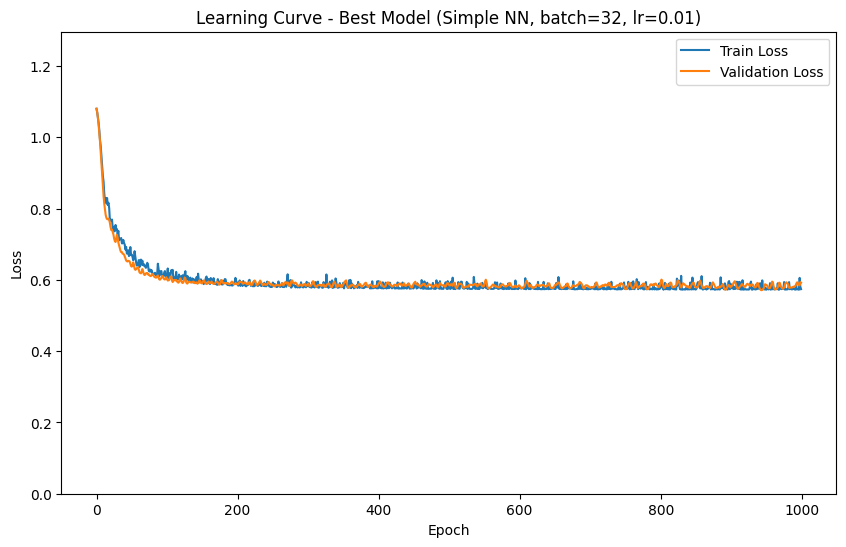

Validation Accuracy: 95.56%
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.85      1.00      0.92        11
           2       1.00      0.89      0.94        18

    accuracy                           0.96        45
   macro avg       0.95      0.96      0.95        45
weighted avg       0.96      0.96      0.96        45



In [348]:
train_dataloader, validation_dataloader = data_pipeline(output='dataloader', batch_size=32, verbose=True, test_size=0.3, random_state=100)

simple_model = SimpleNN() 

simple_trained_model = train_and_evaluate_model(
                        simple_model, 
                        train_dataloader, 
                        validation_dataloader, 
                        epochs=1000, 
                        lr=0.01,
                        verbose=100,
                        model_name="Best Model (Simple NN, batch=32, lr=0.01)"
)

evaluate_model(simple_trained_model, validation_dataloader)

# Conclusions:
- Simple NN model performs better than Complex model in all cases, so we chose the simple model as our best model.
- There is no sign of overfitting in the Simple model.
- Learning rate = 0.01 gives the best result in Simple NN.
- Choosing small or large batch size shows different learning curve, but all of them serve perfect results (100% accuracy, 100% precision and 100% recall) in the Simple NN model.
- The higer the test size, the metrics are worse, they are not 100 % anymore.
- The reason of the perfect result cannot be data leakage, we carefully handled it.
- The perfect predictions with normal test sizes in our Simple Neural Network model seems to be a suspicious result at first, however they are real results. The main possible reason for 100% accuracy is that our dataset is very simple and there are strong correlations between the target variable and the features, as we have seen on the pair plots. We can get 0.64 accuracy even with 10% train data, which shows that this dataset can be well predicted.
- With different random_states, we can get slightly worse accuracy (about 95-97 %) with the Simple NN model. It also demonstrates that 100% accuracy values in some cases are real.
- Furthermore, the Complex NN model does not give such a perfect result, which shows the effectiveness of our Simple NN model.